In [75]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.datasource import YahooDataSource
from src.prediction import PredictionModeling
from src.bayesianopt import bayesianOpt
from src.riskmeasure import CumulativeReturn
from src.utils import buy_signal_plots, calculate_drawdown
from src.utils import find_cointegrated_pairs,get_top_k_pairs,get_cointergrated_coeff
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Data Extraction

In [2]:
# Extract the Data from the Yahoo Data Source
start_date = datetime.datetime(2019, 3, 29)
end_date = datetime.datetime(2024, 3, 29)
tickers  =  ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
columns =   ["High","Close","Low","Volume"]
ds = YahooDataSource(start_date,end_date,tickers,columns)

In [3]:
# Get only Close column data
df_pair_search = ds.get_data_by_column_tickers(columns=["Close"],tickers=-1)

In [4]:
df_pair_search.head(n=5)
scores, pvalues, pairs = find_cointegrated_pairs(df_pair_search)

top_pairs = get_top_k_pairs(pairs,5)
print("Top pairs",top_pairs)

# Get first pair
tickers = ds.get_tickers(top_pairs[0][0])
print("Top ticker",tickers)

Top pairs [(('MSFT_Close', 'AMD_Close'), 0.02034193544966196)]
Top ticker ['MSFT', 'AMD']


In [5]:
first_series = 'MSFT_Close'
second_series =  'AMD_Close'

In [6]:
# Gather High, Low ,Close , Volume of selected stocks
columns = ["High","Close","Low","Volume"]
df_raw = ds.get_data_by_column_tickers(columns=columns,tickers=tickers)

In [7]:
df_raw

,MSFT_Low,MSFT_Close,MSFT_High,MSFT_Volume,AMD_Low,AMD_Close,AMD_High,AMD_Volume
0,110.489776,111.415565,111.774541,25399800,25.250000,25.520000,25.730000,53502800
1,111.566695,112.435799,112.520824,22789100,25.830000,26.360001,26.559999,63000300
2,111.963494,112.596436,112.870394,18142300,26.090000,26.750000,26.799999,53358800
3,112.558637,113.333275,113.767827,22860700,27.879999,29.020000,29.950001,197650500
4,111.831214,112.757004,113.578878,20112800,28.610001,29.090000,29.389999,82191100
...,...,...,...,...,...,...,...,...
1254,422.841793,425.491547,426.603056,17636500,175.050003,179.649994,180.759995,57832100
1255,418.415507,419.656036,424.171580,18060500,172.000000,178.630005,182.800003,71935300
1256,418.157485,418.455200,422.762313,16725600,176.330002,177.869995,182.600006,65322400
1257,415.835230,418.236877,421.234015,16705000,175.399994,179.589996,181.229996,55685600


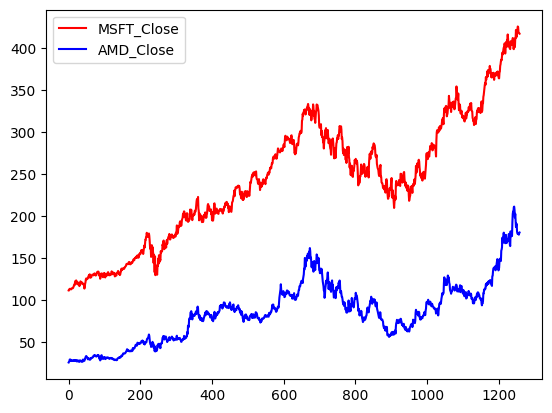

In [8]:
plt.plot(df_raw[first_series],color='r')
plt.plot(df_raw[second_series],color='b')
plt.legend([f'{first_series}',f'{second_series}'])

In [9]:
# Find ratio between co-integrated pairs
coeff = get_cointergrated_coeff(df_raw[first_series],df_raw[second_series])
print(coeff)

-1.9397376995988425


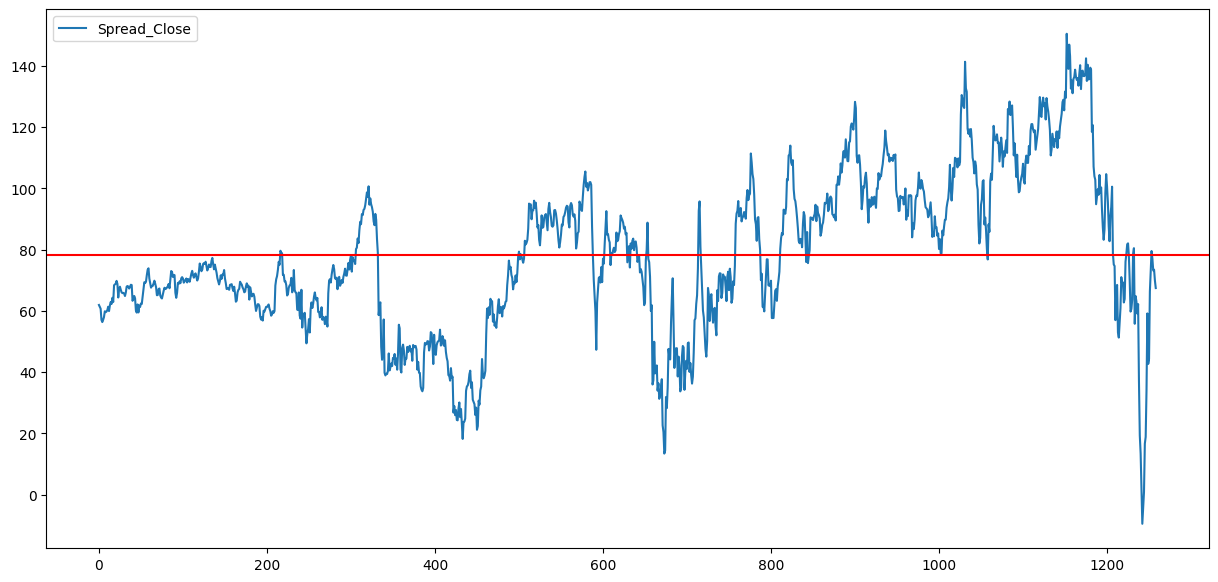

In [10]:
df_raw['Spread_Close'] = df_raw[first_series] + (df_raw[second_series] * coeff)
df_raw['Spread_Close'].plot(figsize=(15,7))
plt.axhline(df_raw['Spread_Close'].mean(),c='red')
plt.legend(['Spread_Close'])

In [11]:
pm = PredictionModeling(df_raw,"Spread_Close",0.60,1)

In [12]:
pm.add_arima_forecast("Spread_Close",order=(1,1,0))

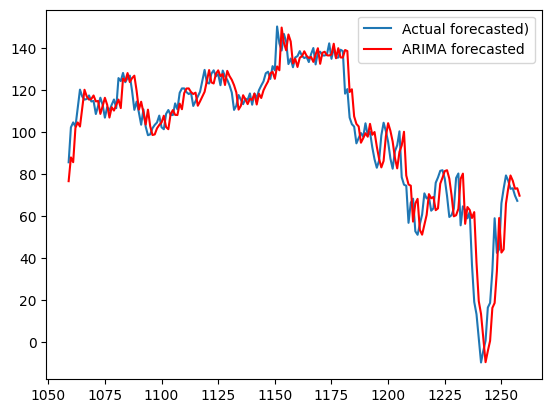

In [13]:
plt.plot(pm.data["Spread_Close_Actual_value_fore_perod_1"][-200:])
plt.plot(pm.data["Spread_Close_ARIMA_forecast_1"][-200:],color='r')
plt.legend(["Actual forecasted)","ARIMA forecasted"])

In [14]:
pm.data

,MSFT_Low,MSFT_Close,MSFT_High,MSFT_Volume,AMD_Low,AMD_Close,AMD_High,AMD_Volume,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1
0,110.489776,111.415565,111.774541,25399800,25.250000,25.520000,25.730000,53502800,61.913459,[61.304311699672105],61.304312,61.304312,NaN,NaN
1,111.566695,112.435799,112.520824,22789100,25.830000,26.360001,26.559999,63000300,61.304312,[60.708452082605966],60.708452,60.708452,NaN,NaN
2,111.963494,112.596436,112.870394,18142300,26.090000,26.750000,26.799999,53358800,60.708452,[57.04208591100873],57.042086,57.042086,NaN,NaN
3,112.558637,113.333275,113.767827,22860700,27.879999,29.020000,29.950001,197650500,57.042086,[56.330033806868876],56.330034,56.330034,NaN,NaN
4,111.831214,112.757004,113.578878,20112800,28.610001,29.090000,29.389999,82191100,56.330034,[57.0440927832545],57.044093,57.044093,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,422.841793,425.491547,426.603056,17636500,175.050003,179.649994,180.759995,57832100,77.017681,[73.1606816262364],73.160682,73.160682,79.506410,[79.50640970578145]
1255,418.415507,419.656036,424.171580,18060500,172.000000,178.630005,182.800003,71935300,73.160682,[73.43406503904185],73.434065,73.434065,77.026265,[77.02626487306657]
1256,418.157485,418.455200,422.762313,16725600,176.330002,177.869995,182.600006,65322400,73.434065,[69.87939107398176],69.879391,69.879391,73.172692,[73.17269218131534]
1257,415.835230,418.236877,421.234015,16705000,175.399994,179.589996,181.229996,55685600,69.879391,[67.42901954176375],67.429020,67.429020,73.433205,[73.4332049105361]


In [15]:
pm.data[:907]

,MSFT_Low,MSFT_Close,MSFT_High,MSFT_Volume,AMD_Low,AMD_Close,AMD_High,AMD_Volume,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1
0,110.489776,111.415565,111.774541,25399800,25.250000,25.520000,25.730000,53502800,61.913459,[61.304311699672105],61.304312,61.304312,NaN,NaN
1,111.566695,112.435799,112.520824,22789100,25.830000,26.360001,26.559999,63000300,61.304312,[60.708452082605966],60.708452,60.708452,NaN,NaN
2,111.963494,112.596436,112.870394,18142300,26.090000,26.750000,26.799999,53358800,60.708452,[57.04208591100873],57.042086,57.042086,NaN,NaN
3,112.558637,113.333275,113.767827,22860700,27.879999,29.020000,29.950001,197650500,57.042086,[56.330033806868876],56.330034,56.330034,NaN,NaN
4,111.831214,112.757004,113.578878,20112800,28.610001,29.090000,29.389999,82191100,56.330034,[57.0440927832545],57.044093,57.044093,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,225.257656,226.491364,233.325657,82543200,59.150002,59.730000,61.770000,79761600,110.630832,[108.34815843128142],108.348158,108.348158,126.215142,[126.21514241024875]
903,221.067031,222.016785,228.811920,40424600,58.509998,58.599998,62.720001,83871400,108.348158,[110.66324911889548],110.663249,110.663249,110.779475,[110.77947538865347]
904,221.331374,230.946381,231.661153,40647700,58.919998,62.009998,62.349998,78198600,110.663249,[110.7838054439723],110.783805,110.783805,108.365034,[108.36503447117734]
905,226.324900,227.284454,230.016208,28357300,59.529999,60.060001,61.860001,73274100,110.783805,[107.68238414767917],107.682384,107.682384,110.645441,[110.64544055653388]


# Data Prepareation of Hyperparameter Tuning for Trading Strategy

In [16]:
total_length =(len(pm.data) - pm.train_end_index)-1
train_size = 0.70
length_param_training = int((len(pm.data) - pm.train_end_index)*0.70)

In [17]:
test_data = pm.data[[first_series,second_series,"Spread_Close","Spread_Close_Actual_value_fore_perod_1","Spread_Close_ARIMA_forecast_1"]][pm.train_end_index:-1]

In [18]:

spread_ARIMA_val = test_data["Spread_Close_ARIMA_forecast_1"][:length_param_training]
S1_val = test_data[first_series][:length_param_training]
S2_val = test_data[second_series][:length_param_training]

spread_ARIMA_test = test_data["Spread_Close_ARIMA_forecast_1"][length_param_training:]

S1_test = test_data[first_series][length_param_training:]
S2_test = test_data[second_series][length_param_training:]

In [19]:
45*4000*6

1080000

# Define set of Hyper parameters

In [20]:
sell_treshold_params = np.linspace(0.4,3,20)
buy_threshold_params = np.linspace(-0.4,-3,20)
clear_threshold_params = np.linspace(0,0.3,10)
window1_param = np.arange(15,100,2)
window2_param = np.arange(1,14,1)
window_param = list(zip(window1_param,window2_param))

param_grid = { 'window1':window1_param,
              'window2':window2_param,
              "sell_threshold":sell_treshold_params,
              "buy_threshold":buy_threshold_params,
              "clear_threshold":clear_threshold_params }
config_dict = {"num_iteration":150}

In [21]:
buy_threshold_params

array([-0.4       , -0.53684211, -0.67368421, -0.81052632, -0.94736842,
       -1.08421053, -1.22105263, -1.35789474, -1.49473684, -1.63157895,
       -1.76842105, -1.90526316, -2.04210526, -2.17894737, -2.31578947,
       -2.45263158, -2.58947368, -2.72631579, -2.86315789, -3.        ])

# Trading Strategy using Trading Strategy using ARIMA

In [81]:
cumilative_return = CumulativeReturn()

In [ ]:
byopt =  bayesianOpt(cumilative_return)
params = byopt.optimize(coeff,spread_ARIMA_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]



Best score: 80494.31966774802: 100%|██████████| 150/150 [01:43<00:00,  1.45it/s]

{'buy_threshold': -3.0, 'clear_threshold': 0.0, 'sell_threshold': 0.4, 'window1': 83, 'window2': 13}


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 489.1086564171874, 973.2519087679802, 1460.2170726164163, 1947.665104420568, 2445.915246819892, 2939.906409477706, 3432.579656408135, 3915.5230953430614, 4404.8356625534925, 4903.3607709520975, 5410.159205412611, 5912.814104302591, 6416.137550500865, 6914.627696771356, 7421.740724583659, 7932.456290775494, 8440.34761691675, 8946.77437455893, 9451.008428804655, 9956.629483524825, 10459.824787304045, 10957.268688443688, 11451.799716868254, 11942.992654788239, 12434.652568354322, 12930.835219090572, 13431.649819210357, 13934.055428730762, 14426.727250637441, 14909.47101716811, 14909.47101716811, 14909.47101716811, 14909.47101716811, 14909.47101716811, 14909.47101716811, 14909.47101716811, 14909.47101716811, 14909.471

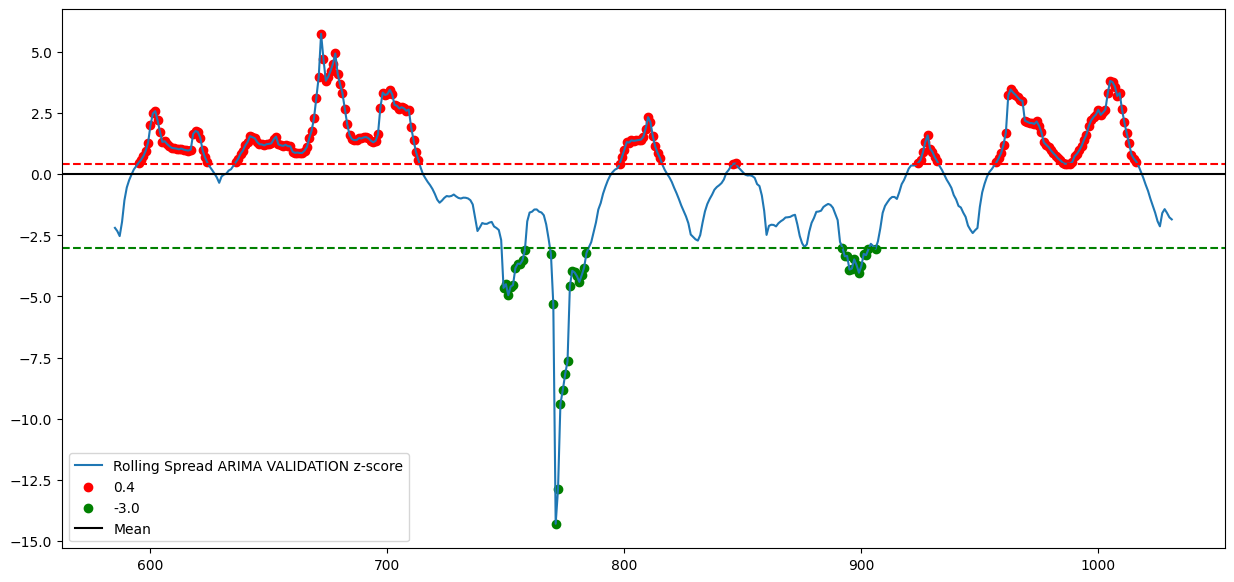

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -501.8068740272553, -996.5210062017522, -1495.9705947489028, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.3578288389535, -2005.35782883

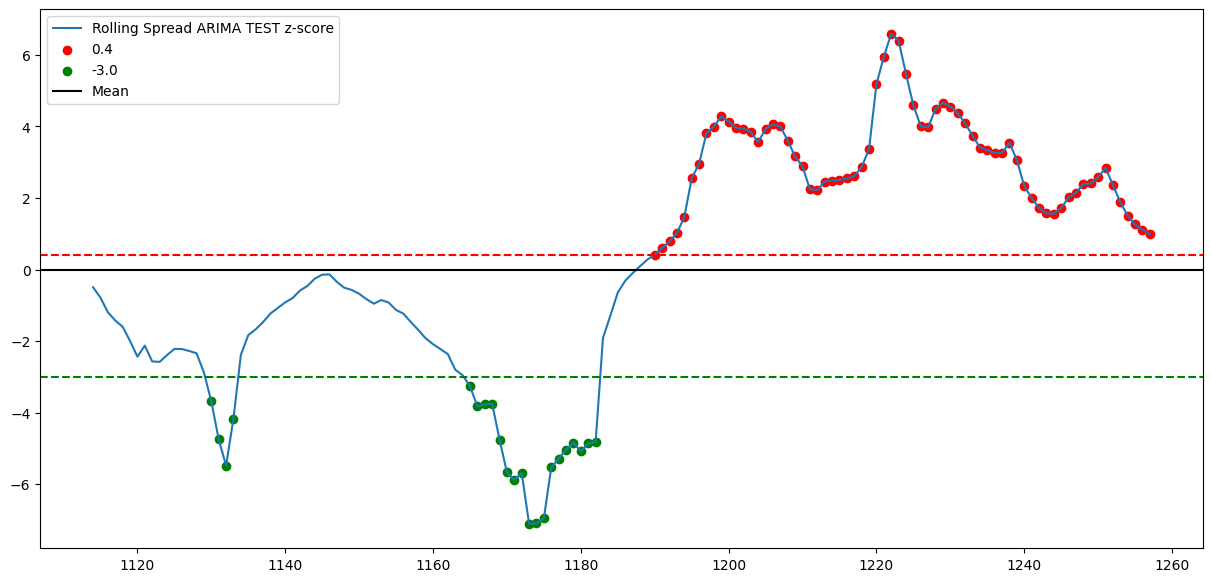

Optimal Parameters {'buy_threshold': -3.0, 'clear_threshold': 0.0, 'sell_threshold': 0.5368421052631579, 'window1': 65, 'window2': 12}
Money on validation data 80494.31966774802
Money on test data 35921.436526574566


In [94]:
money_val = byopt.trade(S1_val,S2_val,spread_ARIMA_val,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)
print(money_val)
buy_signal_plots(spread_ARIMA_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="ARIMA VALIDATION")

money_test = byopt.trade(S1_test,S2_test,spread_ARIMA_test,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)
print(money_test)
buy_signal_plots(spread_ARIMA_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="ARIMA TEST")


print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val[-1])
print("Money on test data",money_test[-1])

In [104]:
rd_window_1 = 65
rd_window_2 = 10
rd_sell_threshold = 1
rd_buy_threshold = -2
rd_clear_threshold = 0

# Optimal Parameters {'buy_threshold': -3.0, 'clear_threshold': 0.0, 'sell_threshold': 0.5368421052631579, 'window1': 65, 'window2': 12}
# Money on validation data 75911.82971778436
# Money on test data 38066.41664118262

In [105]:
money_val_rd = bayesianOpt.trade(S1_val,S2_val,spread_ARIMA_val,coeff,rd_window_1,rd_window_2,rd_sell_threshold,rd_buy_threshold,rd_clear_threshold)
money_val_opt = bayesianOpt.trade(S1_val,S2_val,spread_ARIMA_val,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)

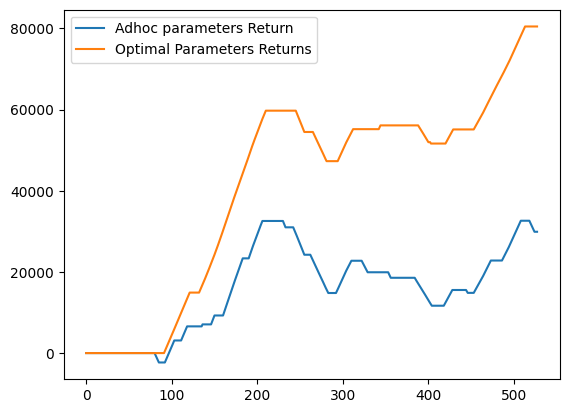

In [106]:
plt.plot(money_val_rd)
plt.plot(money_val_opt)
plt.legend(["Adhoc parameters Return","Optimal Parameters Returns"])

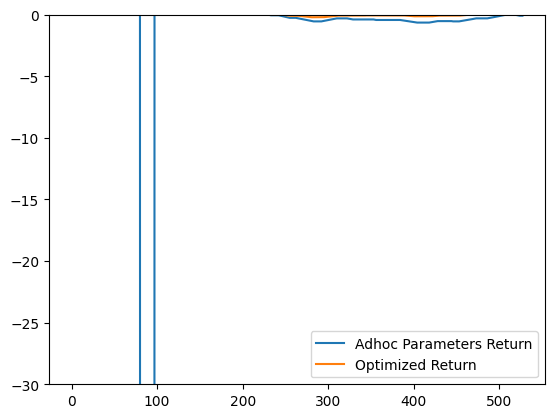

In [107]:
plt.plot(calculate_drawdown(money_val_rd),label="Adhoc Parameters Return")
plt.plot(calculate_drawdown(money_val_opt),label="Optimized Return")
plt.ylim([-30,0])
plt.legend()


In [108]:
val_drawdown = np.min(calculate_drawdown(money_val_rd))
val_opt_drawdown = np.min(calculate_drawdown(money_val_opt))

print("Val drawdown",val_drawdown)
print("Val optimized drawdown",val_opt_drawdown)


Val drawdown -2316.0
Val optimized drawdown -0.2082552222817354


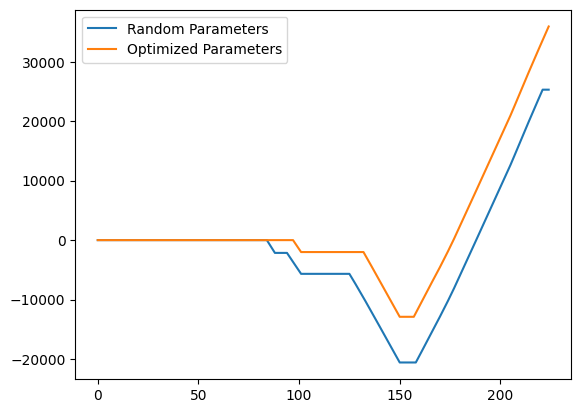

In [109]:
money_test_rd = bayesianOpt.trade(S1_test,S2_test,spread_ARIMA_test,coeff,rd_window_1,rd_window_2,rd_sell_threshold,rd_buy_threshold,rd_clear_threshold)
money_test_opt = bayesianOpt.trade(S1_test,S2_test,spread_ARIMA_test,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)
plt.plot(money_test_rd)
plt.plot(money_test_opt)
plt.legend(["Random Parameters","Optimized Parameters"])

In [110]:
print("Money gain using random parameters",money_test_rd[-1])
print("Money gain using optimized parameters",money_test_opt[-1])

print("Performance gain over benchmark",(money_test_opt[-1]- money_test_rd[-1])/money_test_rd[-1])


Money gain using random parameters 25296.31908645038
Money gain using optimized parameters 35921.436526574566
Performance gain over benchmark 0.4200262261008314


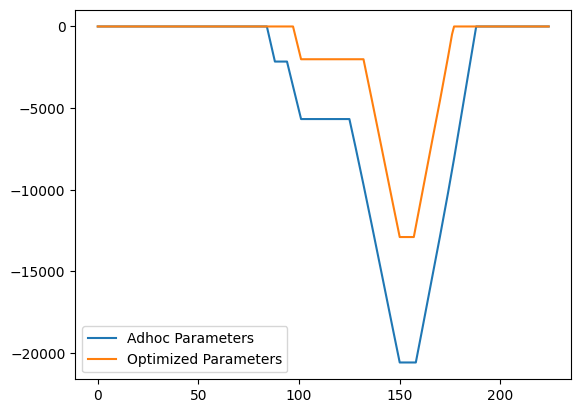

In [112]:
plt.plot(calculate_drawdown(money_test_rd),label="Adhoc Parameters")
plt.plot(calculate_drawdown(money_test_opt),label="Optimized Parameters")
# plt.ylim(-1,0)
plt.legend()

In [113]:
val_test_rd = calculate_drawdown(money_test_rd)
val_test_op = calculate_drawdown(money_test_opt)

print("Test drawdown",np.min(val_test_rd))
print("Test optimized drawdown",np.min(val_test_op))

#Reduction in drawdown
print("Reduction in drawdown",(np.min(val_test_rd)-np.min(val_test_op))/np.min(val_test_rd))



Test drawdown -20571.0
Test optimized drawdown -12891.0
Reduction in drawdown 0.3733411112731515


In [36]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
result = adfuller(pm.data['Spread_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.663120
p-value: 0.004663


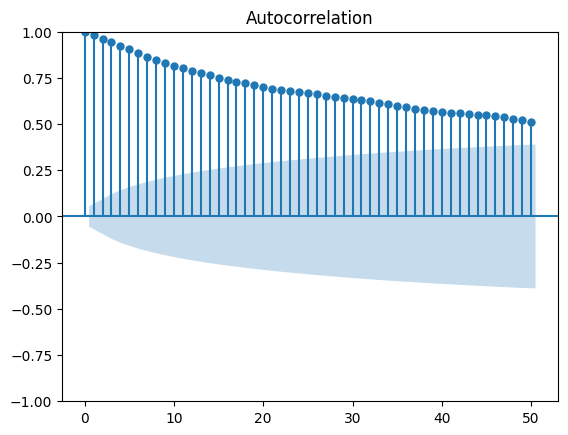

In [ ]:
plot_acf(pm.data['Spread_Close'],lags=50)
plt.show()

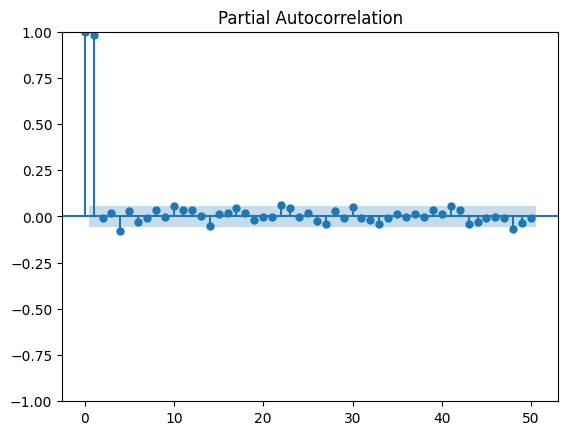

In [135]:
plot_pacf(pm.data['Spread_Close'],lags=50)
plt.show()

In [136]:
result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.470556
p-value: 0.000000


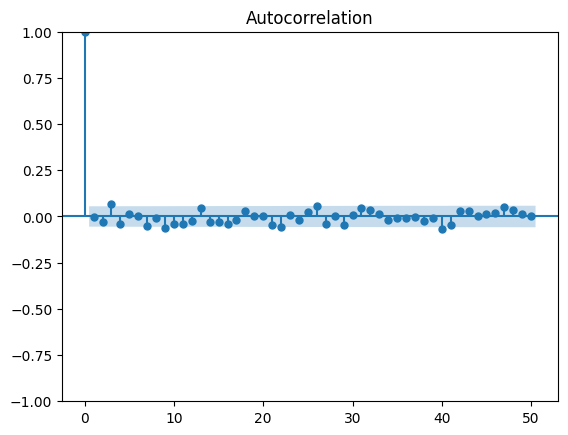

In [137]:
plot_acf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

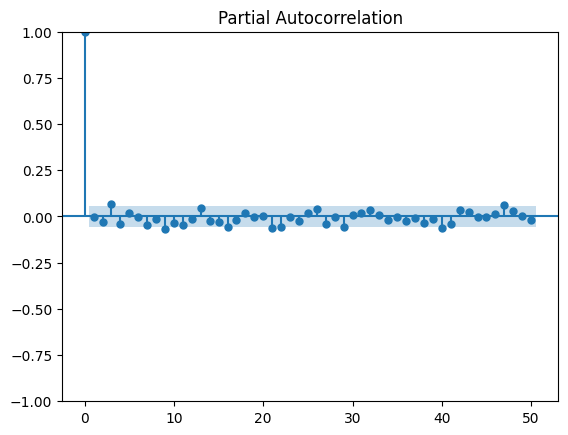

In [138]:
plot_pacf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

In [139]:

result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.470556
p-value: 0.000000
